# Evaluate land model output from perturbed parameter ensemble

This script evaluates model output from a set of ensemble members in a perturbed parameter experiment. It identifies the best-performing ensemble members

## Import modules

In [60]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
import netCDF4 as nc4
import importlib
import esm_tools
importlib.reload(esm_tools)

<module 'esm_tools' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_tools.py'>

## Define paths and script parameters

In [75]:
# Benchmarking metrics
my_metrics = ["BA","AGB","TreeStemD","ShannonE","NPP","FailedPFTs"]

# Optional
case_path = None

# Path where case output lives
case_output_root = '/glade/scratch/adamhb/archive'

# Path to ensemble params
params_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles'

# Path to put any processed output
processed_output_root = '/glade/scratch/adamhb/processed_output'

# Path to param range files
param_range_root = '/glade/u/home/adamhb/california-fates/parameter_ranges/param_range_archive'

## Variables to import

In [55]:
# Keep first two no matter what. They are needed to unravel multi-plexed dimensions
fields = ['FATES_SEED_PROD_USTORY_SZ','FATES_VEGC_AP','FATES_BURNFRAC',
          'FATES_NPLANT_PF','FATES_NPLANT_SZPF','FATES_FIRE_INTENSITY_BURNFRAC','FATES_IGNITIONS',
          'FATES_MORTALITY_FIRE_SZPF','FATES_BASALAREA_SZPF','FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF','FATES_FUEL_AMOUNT_APFC','FATES_NPLANT_SZPF',
          'FATES_PATCHAREA_AP','FATES_CROWNAREA_PF','FATES_VEGC_ABOVEGROUND','FATES_NPP_PF']

## Functions

In [79]:
def setup_benchmarking_data_structure(metrics,parameters,pft_names = pft_names):
    
    metrics_out = metrics.copy()
    
    # add pft-specific vars
    pft_specific_ba_metrics = ["BA_" + pft for pft in pft_names]  
    metrics_out.extend(pft_specific_ba_metrics)
    
    # add inst tag
    metrics_out.append("inst")    
    metrics_out.extend(parameters)
    
    benchmarking_dict = {}
    for i in metrics_out:
        benchmarking_dict[i] = []
    return benchmarking_dict

## Get information about a case

For script dev

In [8]:
full_case_path = esm_tools.get_path_to_sim('conifer-allom-082323a_-17e2acb6a_FATES-55794e61',
                                           case_output_root)

inst_tags = esm_tools.get_unique_inst_tags(full_case_path)
n_inst = len(inst_tags)
print("ninst:",n_inst)

# Generate some test data
inst_files = esm_tools.get_files_of_inst(full_case_path,inst_tags[0],last_n_years=1)
ds = esm_tools.multiple_netcdf_to_xarray(inst_files,fields)

# Test data extraction from netcdf
file_path = esm_tools.get_parameter_file_of_inst(params_root,'conifer_allom_082323a',"0001")
esm_tools.extract_variable_from_netcdf(file_path,"fates_allom_d2ca_coefficient_min",pft_index=1)

ninst: 36


## Benchmarking function

In [82]:
def get_benchmarks(case_name,metrics,last_n_years,param_sub_dir,param_range_file_name,
                   test = False, pft_names = np.array(["pine","cedar","fir","shrub","oak"]),
                   pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen'],
                   param_range_root = param_range_root,
                   params_root = params_root):
      
    print("Case:",case_name)
    
    # 1. Get info about the case
    full_case_path = esm_tools.get_path_to_sim(case_name,case_output_root)
    inst_tags = esm_tools.get_unique_inst_tags(full_case_path)
    
    if test == True:
        inst_tags = inst_tags[:3]
    
    n_inst = len(inst_tags)
    print("ninst:",n_inst)
    
    # 2. Set up the benchmarking data structure
    perturbed_params_df = pd.read_csv(os.path.join(param_range_root,param_range_file_name))
    perturbed_params = []
    for i in range(len(perturbed_params_df)):
        perturbed_params.append(perturbed_params_df['param'][i] + "_" + str(perturbed_params_df['pft'][i]))
    
    bench_dict = setup_benchmarking_data_structure(metrics,perturbed_params,pft_names)  
    print(bench_dict)
                                 
    # 3. Add param values to the data structure
    for inst in inst_tags:
        param_file_path = esm_tools.get_parameter_file_of_inst(params_root,param_sub_dir,inst)
        
        i = 0                      
        for param,pf in zip(perturbed_params_df['param'], perturbed_params_df['pft']):
            i = i + 1
            bench_dict[perturbed_params[i-1]].append(esm_tools.extract_variable_from_netcdf(
                                                           param_file_path,param,pf))
    
    # 4. Add the model output to the data structure
    for inst in inst_tags:
        
        print("Working on ensemble memeber",inst,"of",len(inst_tags),"members")
        
        # Import the model output data for one ensemble member
        inst_files = esm_tools.get_files_of_inst(full_case_path,
                                                 inst,
                                                 last_n_years)
        
        ds = esm_tools.multiple_netcdf_to_xarray(inst_files,fields)
        
        bench_dict['inst'].append(inst)
        
        ## Basal area [m2 ha-1] ##
        if "BA" in bench_dict.keys():
            
            ## Pft-specific BA
            pft_level_ba = esm_tools.get_pft_level_basal_area(ds)
            
            for i in range(len(pft_names)):
                pft_name = pft_names[i]
                bench_dict['BA_' + pft_name].append(pft_level_ba[i])
            
            ## Shannon equitability index (wrt BA) ##
            bench_dict['ShannonE'].append(esm_tools.shannon_equitability(pft_level_ba))
            
            ## Number of failed pfts ##
            bench_dict['FailedPFTs'].append(esm_tools.get_n_failed_pfts(pft_level_ba,ba_thresh=0.1))
            
            ## Total BA
            bench_dict['BA'].append(pft_level_ba.sum())
                  
        ## Stem density [N ha-1] ##
        if "TreeStemD" in bench_dict.keys():
            
            ## Total tree stem density
            bench_dict["TreeStemD"].append(esm_tools.get_total_stem_den(ds,trees_only=False,dbh_min=10))
        
        ## AGB [kg C m-2]
        if "AGB" in bench_dict.keys():
            bench_dict["AGB"].append(esm_tools.get_AGB(ds))
        
        ## Total NPP [kg C m-2]
        if "NPP" in bench_dict.keys():
            bench_dict["NPP"].append(esm_tools.get_total_npp(ds))        
            
        
    return bench_dict

## Ensemble 082323-A

Case: conifer-allom-082323a_-17e2acb6a_FATES-55794e61
ninst: 3
{'BA': [], 'AGB': [], 'TreeStemD': [], 'ShannonE': [], 'NPP': [], 'FailedPFTs': [], 'BA_pine': [], 'BA_cedar': [], 'BA_fir': [], 'BA_shrub': [], 'BA_oak': [], 'inst': [], 'fates_allom_d2ca_coefficient_min_1': [], 'fates_mort_scalar_cstarvation_1': []}
Working on ensemble memeber 0001 of 3 members
Working on ensemble memeber 0002 of 3 members
Working on ensemble memeber 0003 of 3 members


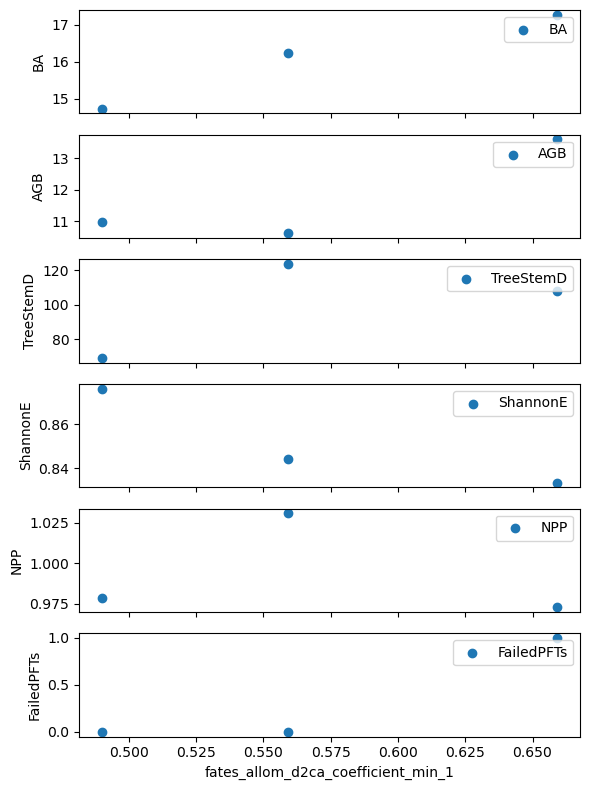

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323a_-17e2acb6a_FATES-55794e61' already exists!


<Figure size 640x480 with 0 Axes>

In [83]:
bench_dict_a = get_benchmarks(case_name='conifer-allom-082323a_-17e2acb6a_FATES-55794e61',
                              metrics = my_metrics,
                              last_n_years=1,
                              param_sub_dir="conifer_allom_082323a",
                              param_range_file_name = 'param_ranges_conifer_allom_test_082323.csv',
                              test=True)
bench_df_a = pd.DataFrame(bench_dict_a)
esm_tools.plot_multi_panel(df = bench_df_a, x_col = "fates_allom_d2ca_coefficient_min_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323a_-17e2acb6a_FATES-55794e61',bench_df_a,processed_output_root = processed_output_root)

## Ensemble 082323-B

Case: conifer-allom-082323b_-17e2acb6a_FATES-55794e61
ninst: 36
{'BA': [], 'AGB': [], 'TreeStemD': [], 'ShannonE': [], 'NPP': [], 'FailedPFTs': [], 'BA_pine': [], 'BA_cedar': [], 'BA_fir': [], 'BA_shrub': [], 'BA_oak': [], 'inst': [], 'fates_allom_d2ca_coefficient_min_1': [], 'fates_mort_scalar_cstarvation_1': []}
Working on ensemble memeber 0001 of 36 members
Working on ensemble memeber 0002 of 36 members
Working on ensemble memeber 0003 of 36 members
Working on ensemble memeber 0004 of 36 members
Working on ensemble memeber 0005 of 36 members
Working on ensemble memeber 0006 of 36 members
Working on ensemble memeber 0007 of 36 members
Working on ensemble memeber 0008 of 36 members
Working on ensemble memeber 0009 of 36 members
Working on ensemble memeber 0010 of 36 members
Working on ensemble memeber 0011 of 36 members
Working on ensemble memeber 0012 of 36 members
Working on ensemble memeber 0013 of 36 members
Working on ensemble memeber 0014 of 36 members
Working on ensemble memebe

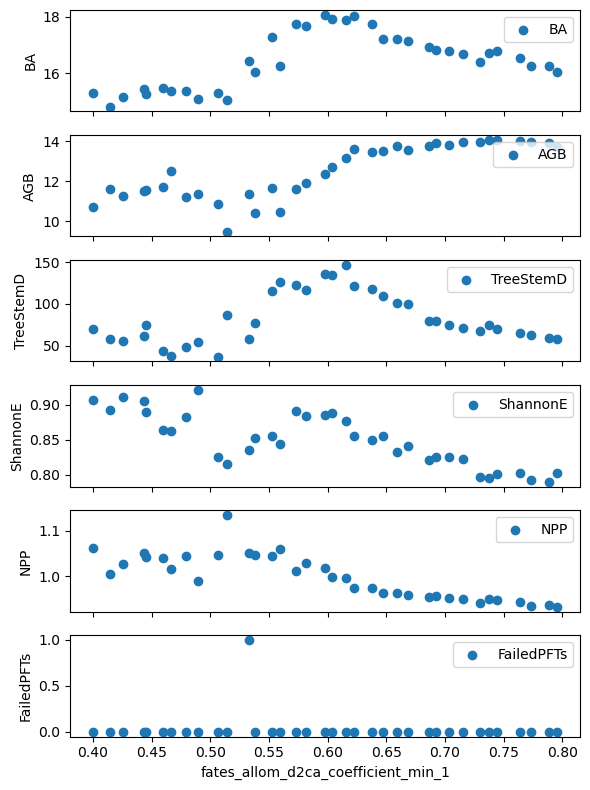

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323b_-17e2acb6a_FATES-55794e61' already exists!


<Figure size 640x480 with 0 Axes>

In [63]:
bench_dict_b = get_benchmarks(case_name='conifer-allom-082323b_-17e2acb6a_FATES-55794e61',
                              metrics = my_metrics,
                              last_n_years=1,
                              param_sub_dir="conifer_allom_082323b",
                              param_range_file_name = 'param_ranges_conifer_allom_test_082323.csv',
                              test=False)
bench_df_b = pd.DataFrame(bench_dict_b)
esm_tools.plot_multi_panel(df = bench_df_b, x_col = "fates_allom_d2ca_coefficient_min_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323b_-17e2acb6a_FATES-55794e61',bench_df_b,processed_output_root = processed_output_root)

## Ensemble 082323-C

Case: conifer-allom-082323c_-17e2acb6a_FATES-55794e61
ninst: 36
{'BA': [], 'AGB': [], 'TreeStemD': [], 'ShannonE': [], 'NPP': [], 'FailedPFTs': [], 'BA_pine': [], 'BA_cedar': [], 'BA_fir': [], 'BA_shrub': [], 'BA_oak': [], 'inst': [], 'fates_allom_blca_expnt_diff_1': []}
Working on ensemble memeber 0001 of 36 members
Working on ensemble memeber 0002 of 36 members
Working on ensemble memeber 0003 of 36 members
Working on ensemble memeber 0004 of 36 members
Working on ensemble memeber 0005 of 36 members
Working on ensemble memeber 0006 of 36 members
Working on ensemble memeber 0007 of 36 members
Working on ensemble memeber 0008 of 36 members
Working on ensemble memeber 0009 of 36 members
Working on ensemble memeber 0010 of 36 members
Working on ensemble memeber 0011 of 36 members
Working on ensemble memeber 0012 of 36 members
Working on ensemble memeber 0013 of 36 members
Working on ensemble memeber 0014 of 36 members


/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_tools.py:222: RuntimeWarning: divide by zero encountered in log
  h_i.append(p[i] * np.log(p[i]))
/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_tools.py:222: RuntimeWarning: invalid value encountered in float_scalars
  h_i.append(p[i] * np.log(p[i]))


Working on ensemble memeber 0015 of 36 members
Working on ensemble memeber 0016 of 36 members
Working on ensemble memeber 0017 of 36 members
Working on ensemble memeber 0018 of 36 members
Working on ensemble memeber 0019 of 36 members
Working on ensemble memeber 0020 of 36 members
Working on ensemble memeber 0021 of 36 members
Working on ensemble memeber 0022 of 36 members
Working on ensemble memeber 0023 of 36 members
Working on ensemble memeber 0024 of 36 members
Working on ensemble memeber 0025 of 36 members
Working on ensemble memeber 0026 of 36 members
Working on ensemble memeber 0027 of 36 members
Working on ensemble memeber 0028 of 36 members
Working on ensemble memeber 0029 of 36 members
Working on ensemble memeber 0030 of 36 members
Working on ensemble memeber 0031 of 36 members
Working on ensemble memeber 0032 of 36 members
Working on ensemble memeber 0033 of 36 members
Working on ensemble memeber 0034 of 36 members
Working on ensemble memeber 0035 of 36 members
Working on en

KeyError: 'fates_allom_blca_expnt_diff'

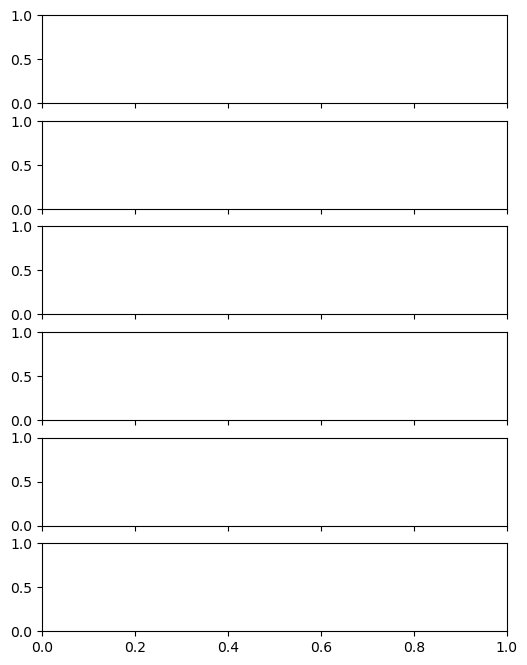

In [64]:
bench_dict_c = get_benchmarks(case_name='conifer-allom-082323c_-17e2acb6a_FATES-55794e61',
                              metrics = my_metrics,
                              last_n_years=1,
                              param_sub_dir="conifer_allom_082323c",
                              param_range_file_name = 'param_ranges_conifer_allom_test_082323c.csv',
                              test=False)
bench_df_c = pd.DataFrame(bench_dict_c)

In [66]:
bench_df_c

,BA,AGB,TreeStemD,ShannonE,NPP,FailedPFTs,BA_pine,BA_cedar,BA_fir,BA_shrub,BA_oak,inst,fates_allom_blca_expnt_diff_1
0,14.178693,5.761178,111.684455,0.296713,1.222952,3,0.001024,0.000960,0.000231,2.594573,11.581904,0001,-0.431720
1,14.153836,5.813097,109.842997,0.274414,1.228377,3,0.000117,0.000030,0.000009,2.280365,11.873316,0002,-0.534461
2,13.791426,5.834028,72.614178,0.270434,1.182241,3,0.001485,0.001525,0.000586,2.148472,11.639357,0003,-0.411212
3,14.031200,7.702048,153.114460,0.591182,1.260122,0,1.047313,0.730097,0.979841,1.009894,10.264055,0004,-0.224542
4,13.838329,7.058952,94.978176,0.494650,1.219112,0,0.633561,0.450185,0.554133,1.329297,10.871153,0005,-0.244624
5,13.152418,5.813034,81.648733,0.208702,1.209890,3,0.000242,0.000110,0.000067,1.378373,11.773626,0006,-0.500661
6,13.977532,10.694774,70.663355,0.850053,1.064123,0,2.705699,1.584764,3.096024,0.437087,6.153958,0007,-0.167520
7,13.663487,5.655820,96.593779,0.270920,1.193156,3,0.000094,0.000095,0.000033,2.154605,11.508661,0008,-0.519609
8,13.841198,6.133086,157.905295,0.169324,1.340327,3,0.006953,0.006702,0.004593,1.009305,12.813644,0009,-0.366311
9,13.525854,5.716500,86.117666,0.250152,1.217166,3,0.000031,0.000049,0.000003,1.875477,11.650294,0010,-0.555036


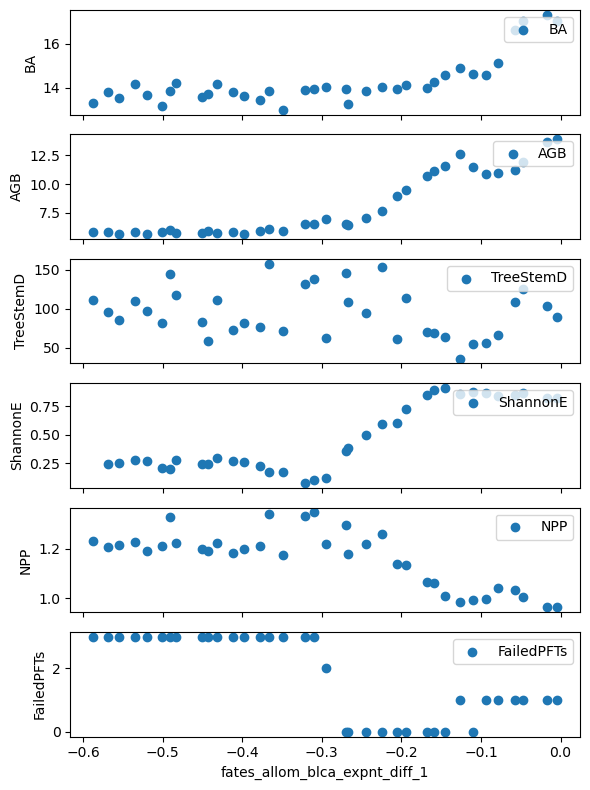

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323c_-17e2acb6a_FATES-55794e61' created successfully!


<Figure size 640x480 with 0 Axes>

In [65]:
esm_tools.plot_multi_panel(df = bench_df_c, x_col = "fates_allom_blca_expnt_diff_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323c_-17e2acb6a_FATES-55794e61',bench_df_c,processed_output_root = processed_output_root)

## Ensemble 082323-D

In [67]:
bench_dict_d = get_benchmarks(case_name='conifer-allom-082323d_-17e2acb6a_FATES-55794e61',
                              metrics = my_metrics,
                              last_n_years=1,
                              param_sub_dir="conifer_allom_082323d",
                              param_range_file_name = 'param_ranges_conifer_allom_test_082323d.csv',
                              test=False)
bench_df_d = pd.DataFrame(bench_dict_d)

Case: conifer-allom-082323d_-17e2acb6a_FATES-55794e61
ninst: 36
{'BA': [], 'AGB': [], 'TreeStemD': [], 'ShannonE': [], 'NPP': [], 'FailedPFTs': [], 'BA_pine': [], 'BA_cedar': [], 'BA_fir': [], 'BA_shrub': [], 'BA_oak': [], 'inst': [], 'fates_allom_d2h1_1': [], 'fates_allom_d2h2_1': [], 'fates_allom_dbh_maxheight_1': []}
Working on ensemble memeber 0001 of 36 members
Working on ensemble memeber 0002 of 36 members
Working on ensemble memeber 0003 of 36 members
Working on ensemble memeber 0004 of 36 members
Working on ensemble memeber 0005 of 36 members
Working on ensemble memeber 0006 of 36 members
Working on ensemble memeber 0007 of 36 members
Working on ensemble memeber 0008 of 36 members
Working on ensemble memeber 0009 of 36 members
Working on ensemble memeber 0010 of 36 members
Working on ensemble memeber 0011 of 36 members
Working on ensemble memeber 0012 of 36 members
Working on ensemble memeber 0013 of 36 members
Working on ensemble memeber 0014 of 36 members
Working on ensemble 

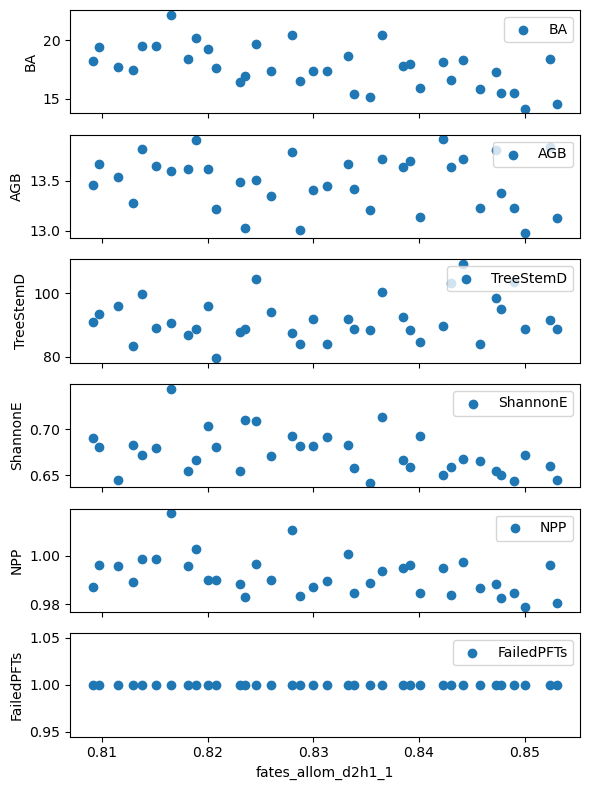

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323d_-17e2acb6a_FATES-55794e61' created successfully!


<Figure size 640x480 with 0 Axes>

In [68]:
esm_tools.plot_multi_panel(df = bench_df_d, x_col = "fates_allom_d2h1_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323d_-17e2acb6a_FATES-55794e61',bench_df_d,processed_output_root = processed_output_root)

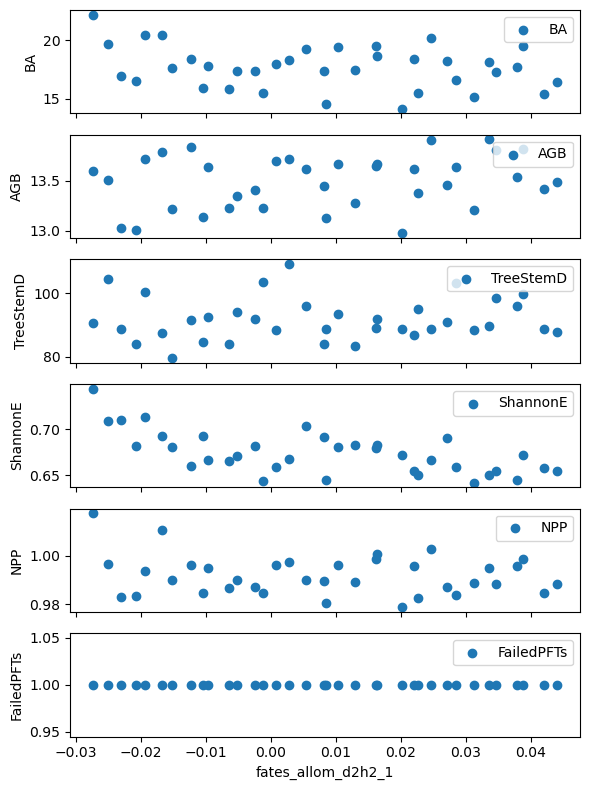

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323d_-17e2acb6a_FATES-55794e61' already exists!


<Figure size 640x480 with 0 Axes>

In [69]:
esm_tools.plot_multi_panel(df = bench_df_d, x_col = "fates_allom_d2h2_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323d_-17e2acb6a_FATES-55794e61',bench_df_d,processed_output_root = processed_output_root)

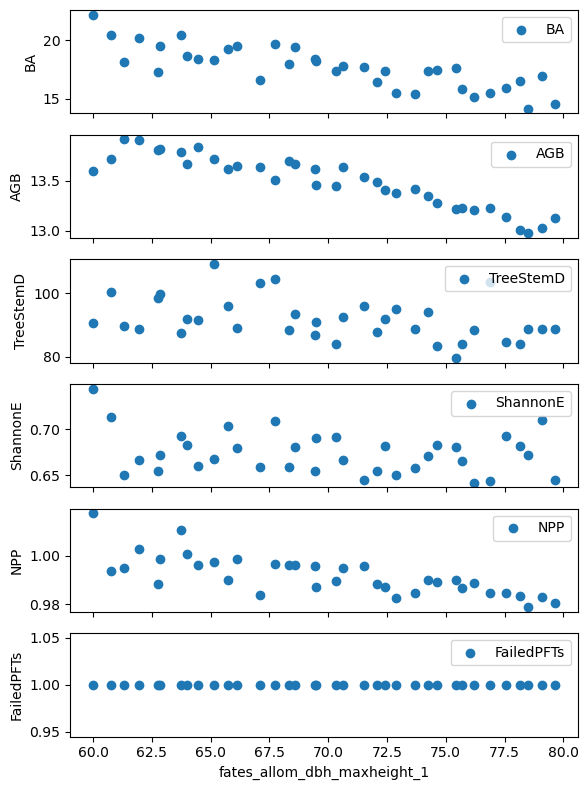

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323d_-17e2acb6a_FATES-55794e61' already exists!


<Figure size 640x480 with 0 Axes>

In [70]:
esm_tools.plot_multi_panel(df = bench_df_d, x_col = "fates_allom_dbh_maxheight_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323d_-17e2acb6a_FATES-55794e61',bench_df_d,processed_output_root = processed_output_root)

## Ensemble 082323-E

In [73]:
pft_names = np.array(["pine","cedar","fir"])
pft_colors = ['gold','darkorange','darkolivegreen']

bench_dict_e = get_benchmarks(case_name='conifer-allom-082323e_-17e2acb6a_FATES-55794e61',
                              metrics = my_metrics,
                              last_n_years=1,
                              param_sub_dir="conifer_allom_082323e",
                              param_range_file_name = 'param_ranges_conifer_allom_test_082323.csv',
                              test=False)

bench_df_e = pd.DataFrame(bench_dict_e)

Case: conifer-allom-082323e_-17e2acb6a_FATES-55794e61
ninst: 36
{'BA': [], 'AGB': [], 'TreeStemD': [], 'ShannonE': [], 'NPP': [], 'FailedPFTs': [], 'BA_pine': [], 'BA_cedar': [], 'BA_fir': [], 'inst': [], 'fates_allom_d2ca_coefficient_min_1': [], 'fates_mort_scalar_cstarvation_1': []}
Working on ensemble memeber 0001 of 36 members
Working on ensemble memeber 0002 of 36 members
Working on ensemble memeber 0003 of 36 members
Working on ensemble memeber 0004 of 36 members
Working on ensemble memeber 0005 of 36 members
Working on ensemble memeber 0006 of 36 members
Working on ensemble memeber 0007 of 36 members
Working on ensemble memeber 0008 of 36 members
Working on ensemble memeber 0009 of 36 members
Working on ensemble memeber 0010 of 36 members
Working on ensemble memeber 0011 of 36 members
Working on ensemble memeber 0012 of 36 members
Working on ensemble memeber 0013 of 36 members
Working on ensemble memeber 0014 of 36 members
Working on ensemble memeber 0015 of 36 members
Working o

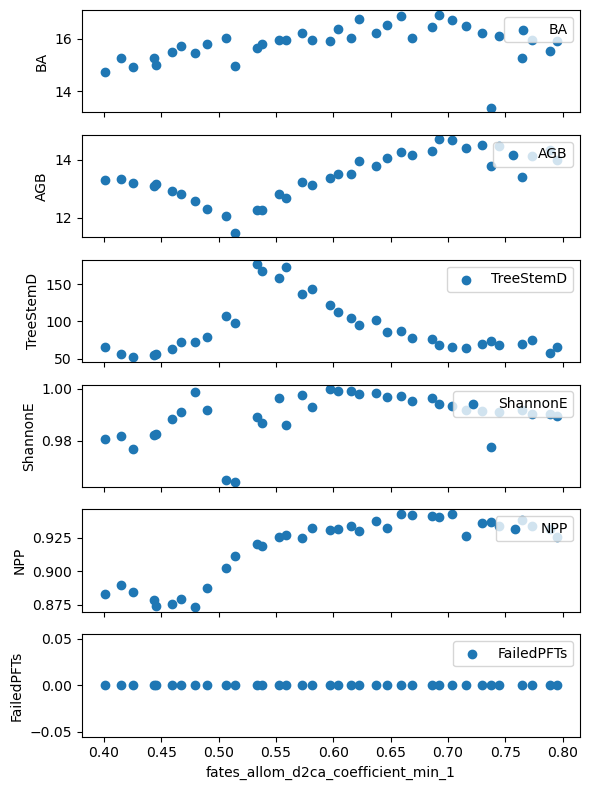

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323e_-17e2acb6a_FATES-55794e61' created successfully!


<Figure size 640x480 with 0 Axes>

In [74]:
esm_tools.plot_multi_panel(df = bench_df_e, x_col = "fates_allom_d2ca_coefficient_min_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323e_-17e2acb6a_FATES-55794e61',bench_df_e,processed_output_root = processed_output_root)

## Apply benchmarking function to multiple cases

In [ ]:
multi_case_benchmarks = []
for c in cases:
     multi_case_benchmarks.append(get_benchmarks(c,metrics = my_metrics, last_n_years=1,test=True))
multi_case_benchmarks

### Functions

In [ ]:
def agefuel_to_age_by_fuel(agefuel_var, dataset):
    n_age = len(dataset.fates_levage)
    ds_out = (agefuel_var.rolling(fates_levagefuel = n_age, center=False).construct("fates_levage")
          .isel(fates_levagefuel=slice(n_age-1, None, n_age))
          .rename({'fates_levagefuel':'fates_levfuel'})
          .assign_coords({'fates_levage':dataset.fates_levage})
          .assign_coords({'fates_levfuel':np.array([1,2,3,4,5,6])}))
    return ds_out
    #ds_out.attrs['long_name'] = agefuel_var['long_name']
    #ds_out.attrs['units'] = agefuel_var['units']

def scpf_to_scls_by_pft(scpf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_scls = len(dataset.fates_levscls)
    ds_out = (scpf_var.rolling(fates_levscpf=n_scls, center=False)
            .construct("fates_levscls")
            .isel(fates_levscpf=slice(n_scls-1, None, n_scls))
            .rename({'fates_levscpf':'fates_levpft'})
            .assign_coords({'fates_levscls':dataset.fates_levscls})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)



def get_last_file_of_sim(sim_path):
    files = sorted(os.listdir(sim_path))
    full_files = [os.path.join(sim_path,f) for f in files]
    last_file = full_files[-1]
    return last_file



def open_fates_hist_file(file):
    ds = xr.open_dataset(file)
    ds = ds.sel(lndgrid=0)
    return ds

def get_total_stem_den(file):
    ds = open_fates_hist_file(file)
    den_total = ds.FATES_NPLANT_PF.sum(dim="fates_levpft")
    den_shrub = ds.FATES_NPLANT_PF.isel(fates_levpft = 3)
    den_trees = den_total - den_shrub
    den_trees = den_trees.values * m2_per_ha
    return den_trees

def get_total_npp(file):
    ds = open_fates_hist_file(file)
    npp_total = ds.FATES_NPP_PF.sum(dim="fates_levpft").values * s_per_yr
    return npp_total

def get_AGB(file):
    ds = open_fates_hist_file(file)
    agb_total = ds.FATES_VEGC_ABOVEGROUND.values 
    return agb_total

def get_fuel(file):
    ds = open_fates_hist_file(file)
    age_by_fuel = agefuel_to_age_by_fuel(ds.FATES_FUEL_AMOUNT_APFC,ds)
    fates_fuel_amount_by_class = age_by_fuel.sum(dim = "fates_levage") #sum over patches
    trunk = fates_fuel_amount_by_class.isel(fates_levfuel = 3)
    total = fates_fuel_amount_by_class.sum(dim = "fates_levfuel")
    burnable = total - trunk
    return burnable.values[0]

def get_pft_level_basal_area(file,dbh_min):
    ds = open_fates_hist_file(file)
    basal_area = scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds)
    basal_area = basal_area.sel(fates_levscls = slice(dbh_min,None))
    basal_area_pf = basal_area.sum(axis=2).values * m2_per_ha
    return basal_area_pf

def get_total_tree_basal_area(file,dbh_min):
    ds = open_fates_hist_file(file)
    basal_area = scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds)
    basal_area = basal_area.sel(fates_levscls = slice(dbh_min,None))
    basal_area_pf = basal_area.sum(axis=2) * m2_per_ha
    basal_area_total = basal_area_pf.sum(axis = 1)
    basal_area_shrub = basal_area_pf.isel(fates_levpft = 3)
    basal_area_tree = basal_area_total-basal_area_shrub
    return basal_area_tree.values[0]

def get_size_class_distribution(file,dbh_min):
    ds = open_fates_hist_file(file)
    basal_area = scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds)
    basal_area = basal_area.sel(fates_levscls = slice(dbh_min,None))
    basal_area_pf = basal_area.values * m2_per_ha
    return basal_area_pf

def get_shrub_crown_area(file):
    ds = open_fates_hist_file(file)
    shrub_canopy_cover = ds.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft = 3).values[0]
    return shrub_canopy_cover

def get_diff_table(site,var,d):
    d_site = d.loc[d["site"].str.contains(site),:]
    d_site['delta'] = d_site[var] - d_site.iloc[-1,1]
    d_site['delta_pct'] = d_site['delta'] / d_site[var]
    return d_site

def get_diff_table(site,var):
    d_site = d.loc[d["site"].str.contains(site),:]
    d_site['delta'] = d_site[var] - d_site.iloc[-1,1]
    d_site['delta_pct'] = d_site['delta'] / d_site[var]
    return d_site

### Fuel loads

In [ ]:
get_last_file_of_sim(get_path_to_sim(site_names[1]))
ds = open_fates_hist_file(file)
age_by_fuel = agefuel_to_age_by_fuel(ds.FATES_FUEL_AMOUNT_APFC,ds)
fates_fuel_amount_by_class = age_by_fuel.sum(dim = "fates_levage") #sum over patches
trunk = fates_fuel_amount_by_class.isel(fates_levfuel = 3)
total = fates_fuel_amount_by_class.sum(dim = "fates_levfuel")
burnable = total - trunk
burnable.values[0]
#print("total", total.dims)
#print(trunk.dims)


In [ ]:
#PFT-level basal area in final timestep for each pft
site = []
den = []
my_dict = {}
for i,c in enumerate(sim_names):
    print("working on scenario ",c)
    tmp_fuel = get_fuel(get_last_file_of_sim(get_path_to_sim(c)))
    print(tmp_fuel)
    my_dict[c] = tmp_fuel
    #yourdict = {k:v for k,v in zip(keys, values)}

    
#d = pd.DataFrame({'site':site,'fuel':den})
#d.to_csv(os.path.join(path_for_output,batch_tag + "_AGB.csv"))

### Get the size class distribution at the end of the simulation at many sites

In [ ]:
my_dict

In [ ]:
fuel_df = pd.DataFrame.from_dict(my_dict, orient='index', columns=["burnable"])
fuel_df = fuel_df.rename_axis("site").reset_index()
get_diff_table("stan","burnable",d=fuel_df)

In [ ]:
pd.DataFrame.from_dict(my_dict, orient='index', columns=["site","leaf","sm_br","lg_br","trunk","grass"])

In [ ]:
c = sim_names[1]
print(c)
dbh_min = 0.

file = get_last_file_of_sim(get_path_to_sim(c))

ds = open_fates_hist_file(file)
basal_area = scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds)
basal_area = basal_area.sel(fates_levscls = slice(dbh_min,None))
basal_area_pf = basal_area * m2_per_ha
basal_area_pf = basal_area_pf[0,:,:]


# Sample data
data = basal_area_pf.sum(axis = 0)

# Number of bars
num_bars = len(data.values)

# Create bar positions
bar_positions = data.fates_levscls.values

# Plot the bars
plt.bar(bar_positions, data.values)

# Customize the chart
plt.xlabel('Size Class [cm]')
plt.ylabel('BA [m2 ha-1]')
plt.title('Stanislaus')
plt.xticks(data.fates_levscls.values)

# Display the chart
plt.show()
# fig, axes = plt.subplots(ncols=ncol,nrows=nrow,figsize=(12,10))
# for size,ax in zip(range(len(basal_area_pf.fates_levscls.values)),axes.ravel()):

#          cca = xarr.isel(fates_levage = age) / xds.FATES_PATCHAREA_AP.isel(fates_levage = age)

#          for p in range(n_pfts):
#              cca.isel(fates_levpft=p).plot(x = "time",
#                       color = pft_colors[p],lw = 3,add_legend = True,
#                       label = pft_names[p], ax = ax)

#              #plt.legend()
#          ax.set_title('{} yr old patches'.format(xds.fates_levage.values[age]))
#          ax.set_ylabel(ylabel,fontsize = int(12 * 0.75))
#          ax.xaxis.set_major_formatter(DateFormatter('%Y'))
#          #ax.xaxis.set_major_locator(mdates.YearLocator(base=nbase))

#     plt.tight_layout()
#     plt.subplots_adjust(hspace=1,wspace=0.2)
#     fig.suptitle(sup_title, fontsize=12,y=0.99)


In [ ]:
site_names

### Stem density distribution

In [ ]:
c = sim_names[1]
print(c)
dbh_min = 0.

file = get_last_file_of_sim(get_path_to_sim(c))

ds = open_fates_hist_file(file)
basal_area = scpf_to_scls_by_pft(ds.FATES_NPLANT_SZPF, ds)
basal_area = basal_area.sel(fates_levscls = slice(dbh_min,None))
basal_area_pf = basal_area * m2_per_ha
basal_area_pf = basal_area_pf[0,:,:]


# Sample data
data = basal_area_pf.sum(axis = 0)

# Number of bars
num_bars = len(data.values)

# Create bar positions
bar_positions = data.fates_levscls.values

# Plot the bars
plt.bar(bar_positions, data.values)

# Customize the chart
plt.xlabel('Size Class [cm]')
plt.ylabel('Density [N ha-1]')
plt.title('Stanislaus')
plt.xticks(data.fates_levscls.values)
plt.show()

### Size Class Distribution

### Basal Area by Size Class and PFT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
data = basal_area_pf

num_groups, num_bars = data.shape
bar_width = 0.35
opacity = 0.8

# Create subplots for each group
fig, axes = plt.subplots(nrows=num_groups, ncols=1, figsize=(5, num_groups * 5), sharey=True)

# Iterate over the groups and create bar plots
for group_idx, ax in enumerate(axes):
    ax.bar(np.arange(num_bars), data[group_idx, :], width=bar_width, alpha=opacity)

    # Customize each subplot
    ax.set_title(f'PFT: {pft_names[group_idx]}')
    ax.set_xticks(np.arange(num_bars))
    ax.set_xticklabels(basal_area_pf.fates_levscls.values)
    ax.set_ylabel("BA [m2 ha-1]")
    ax.set_xlabel("Size Class [cm]")

# Set common labels
fig.text(0.5, 0.04, 'Bar', ha='center', va='center')
fig.text(0.06, 0.5, 'Values', ha='center', va='center', rotation='vertical')

# Display the facetted bar plots
plt.show()